In [1]:
import numpy as np
import time
import pandas as pd
from astropy.io import fits
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from matplotlib import pyplot as plt
import os



# 网络模型-系统试验

目录

>- lenet型卷积网络
>   - lenet1
>       - 3层2*2正常卷积，通道扩张，3层2\*2最大池化，3层桶全连接，relu
>   - lenet2
>       - 5层2*2正常卷积，通道扩张，5层2\*2最大池化，3层桶全连接，relu
>   - lenet3
>       - 7层2*2正常卷积，通道扩张，7层2\*2最大池化，3层桶全连接，relu

>- alexnet型卷积网络
>   - alexnet1
>       - 两并行：[11\*11，5\*5，3\*3\*3]\*2，通道扩张，dropout，3层2\*2最大池化，两层桶全连接，relu
>   - alexnet2
>       - 两并行：[11\*11，5\*5，3\*3]，通道扩张，dropout，2层2\*2最大池化，2层桶全连接，relu
>   - alexnet3
>       - 两并行：[11\*11,5\*5,3\*3\*5]，通道扩张，dropout，4层2\*2最大池化，2层桶全连接，relu

>- VCGNet型卷积网络
>   - vcgnet1
>       - (2层3\*3Conv+MaxPool)\*2 + (3层3\*3Conv+MaxPool)\*3 + 2\*fc（桶），通道扩张，same卷积，2\*2池化步长2
>   - vcgnet2
>       - (2层3\*3Conv+MaxPool)\*2 + (3层3\*3Conv+MaxPool)\*1 + 2\*fc（桶），通道扩张，same卷积，2\*2池化步长2
>   - vcgnet3
>       - (2层3\*3Conv+MaxPool)\*1 + (3层3\*3Conv+MaxPool)\*1 + 2\*fc（桶），通道扩张，same卷积，2\*2池化步长2

>- Inception型卷积网络
>   - Inception1
>       - 四并行：[11\*11，5\*5，3\*3\*3]\*4+[1\*1|1\*1+3\*3|1\*1+5\*5|3\*3p+1*1]
>       - 四并行：[11\*11，5\*5，3\*3\*3]+[11\*11，5\*5，3\*3]+[3\*3\*3]
>
>


In [24]:
class LeNet1(nn.Module):
    def __init__(self):
        super(LeNet1,self).__init__()
        self.c1 = nn.Conv2d(1, 2, 2)
        self.c2 = nn.Conv2d(2, 4, 2)
        self.c3 = nn.Conv2d(4, 8, 2)
        self.p1 = nn.MaxPool2d(2)
        self.p2 = nn.MaxPool2d(2)
        self.p3 = nn.MaxPool2d(2)
        self.f1 = nn.Linear(968, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 1)
        self.relu = nn.LeakyReLU(0.05)
        
    def forward(self, x):
        x_size = x.size(0)
        x = self.c1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.p2(x)
        x = self.c3(x)
        x = self.p3(x)
        x = self.relu(x)
        
        x = x.view(x_size,-1)
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        x = self.relu(x)
        x = self.f3(x)
        x = self.relu(x)
        return x

In [30]:
model = LeNet1()
data = np.random.rand(1,1,100,100)+100
data = torch.tensor(data)
model(data.float())

tensor([[0.7118]], grad_fn=<LeakyReluBackward0>)

# 数据读取与预处理

数据文件读取

In [49]:
data_path = '/home/haoyanzhen_shao/project/nn_cf/'

os.system('ls ./dataset/image/ > ./dataset/image/image.list')
os.system('ls ./dataset/catalog/ > ./dataset/catalog/catalog.list')

datas,labels = [],[]
with open('./dataset/image/image.list') as f:
    fl = f.readlines()[:-1]  # 去掉索引文件本身
    # print(fl)
    for i in fl:
        i = i.strip()
        path = data_path+'/dataset/image/'+i
        img = fits.open(path)[1].data
        img = img.astype('float32')  # img.dtype=np.int32会改变原数组的dtype与数字内容。。。（会变成一个大数）
        datas.append(img)
with open('./dataset/catalog/catalog.list') as f:
    fl = f.readlines()[:-1]  # 去掉索引文件本身
    for i in fl:
        i = i.strip()
        path = data_path+'/dataset/catalog/'+i
        cat = pd.read_csv(path)
        labels.append(len(cat))
del fl,path,img,cat
        


数据归一化

In [61]:
datas_mean = np.mean(datas,axis=(1,2),keepdims=True)
datas_std = np.std(datas,axis=(1,2),keepdims=True)
datas = (np.array(datas) - datas_mean) / datas_std
# labels_std = np.std(labels)
# labels = np.array(labels)/labels_std**2
labels_max = np.array(labels).max()
labels_min = np.array(labels).min()
labels = (labels-labels_min)/(labels_max-labels_min)
labels

array([0.21843003, 0.32423208, 0.28327645, ..., 0.70307167, 0.63822526,
       0.64505119])

In [73]:
# labels = labels*labels_std**2
labels = labels*(labels_max-labels_min) + labels_min
datas = datas*datas_std+datas_mean

In [54]:
len(labels),len(datas),np.max(labels)

(8464, 8464, 786.0)

In [74]:
labels.max()

786.0

训练数据集定义

In [75]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class CSSTSimDataset(Dataset):
    def __init__(self,datas,labels,transfrom=None):
        self.datas = datas
        self.labels = labels
    
    def __getitem__(self, index):
        data = torch.tensor(self.datas[index]).unsqueeze(0)  # 增加一个色彩维度（channel）
        label = torch.tensor(self.labels[index])
        return data, label
    
    def __len__(self):
        return len(self.labels)
    

# transfrom = transforms.Compose(
#     [transforms.ToTensor(),])
dataset = CSSTSimDataset(datas,labels)


训练定义

In [76]:
batch = 128
split = 0.8

train_size = int(split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=batch,
                        sampler=None,
                        num_workers=0,)
testloader = DataLoader(test_dataset, batch_size=batch)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cuda', index=0)

# 训测集成

> 训测

In [130]:
if 0:
    model = torch.load('').to(device)
else:
    model = Complexcnnfit1().to(device)

In [137]:
def test(model, device, test_loader, epoch):
    model.eval()
    # correct = 0
    loss = 0
    for idx, (x, y) in enumerate(test_loader):
        x, y= x.to(device), y.to(device)
        predict = model(x).view(-1)
        # predict_class = predict.round()
        # correct += predict_class.eq(y.view_as(predict_class)).sum().item()
    # accuracy = correct/len(test_loader)
    # print(">>>accuracy[%s]=============>%s" %(epoch, accuracy))
    # return accuracy
        loss += F.mse_loss(predict, y.float())
    test_loss = loss.item()/len(test_loader)
    print(">>>accuracy[%s]=============>%s" %(epoch, test_loss))
    return test_loss

def trainteststep(model, device, train_loader, optimizer, epoch, loss_list, test_loader, acclist):
    model.train()
    lossidx = 0
    for idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        predict = model(data).view(-1)
        #print("pre:", predict.T)
        #print("label:", label)
        # loss = F.binary_cross_entropy(predict, label.float())
        loss = F.mse_loss(predict, label.float())
        
        loss.backward()
        optimizer.step()

        lossidx += loss.item()
        if (idx+1)%10 == 0:
            print("[%s]==<%s>---------->%s" %(epoch, idx+1, lossidx/10))
            loss_list.append(lossidx/10)
            lossidx = 0
    accuracy = test(model,device,test_loader,epoch)
    acclist.append(accuracy)


losslist = []
acclist = []
epoch = 80
opt = optim.Adam(model.parameters(),lr=0.0001)
for i in range(epoch):
    if i > epoch/2:
        opt = optim.Adam(model.parameters(),lr=0.0001*np.exp(-np.log(epoch/2)/epoch/2*i))
    trainteststep(model, device, trainloader, opt, i, losslist, testloader, acclist)


[0]==<10>---------->779.6283996582031
[0]==<20>---------->811.9197448730469
[0]==<30>---------->752.8504211425782
[0]==<40>---------->844.5106567382812
[0]==<50>---------->738.8758544921875
>>>accuracy[0]=============>1116.34765625
[1]==<10>---------->797.0887268066406
[1]==<20>---------->704.1560668945312
[1]==<30>---------->693.0981750488281
[1]==<40>---------->894.7500366210937
[1]==<50>---------->738.0356079101563
>>>accuracy[1]=============>1096.1217215401787
[2]==<10>---------->723.2810668945312
[2]==<20>---------->758.1897888183594
[2]==<30>---------->777.3180847167969
[2]==<40>---------->798.7390380859375
[2]==<50>---------->765.6952270507812
>>>accuracy[2]=============>1093.59716796875
[3]==<10>---------->717.0783447265625
[3]==<20>---------->854.4953674316406
[3]==<30>---------->783.6647583007813
[3]==<40>---------->728.8855163574219
[3]==<50>---------->727.5211853027344
>>>accuracy[3]=============>1091.4185965401787
[4]==<10>---------->714.2508361816406
[4]==<20>---------->7

> 准确率可视化

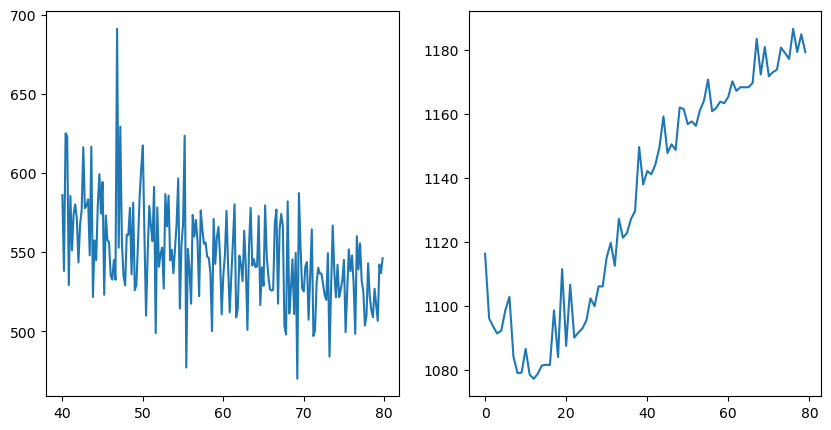

In [139]:
epoch_list = np.array(range(epoch*(len(trainloader)//10)))/(len(trainloader)//10)

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epoch_list[200:],losslist[200:])
plt.subplot(122)
plt.plot(range(epoch)[:],acclist[:])

> 保存模型

In [140]:
torch.save(Simplecnnfit2,'./model/models-complexcnnfit1_{:.2f}.pth'.format(acclist[-1]))

> 详细查看

In [100]:
for i, (x,y) in enumerate(testloader):
    x,y = x.to(device),y.to(device)
    print('num:%s, predict:%s'%(y,model(x)))

num:tensor([692., 733., 584., 644., 712., 703., 668., 644., 705., 711., 728., 713.,
        742., 637., 693., 704., 740., 712., 690., 711., 700., 701., 677., 719.,
        713., 680., 714., 651., 706., 669., 652., 693., 720., 722., 726., 718.,
        632., 741., 691., 685., 749., 657., 662., 673., 630., 654., 715., 645.,
        705., 708., 702., 708., 687., 675., 670., 707., 652., 715., 679., 675.,
        675., 686., 655., 690., 692., 685., 697., 682., 671., 692., 684., 714.,
        671., 747., 670., 697., 713., 707., 701., 670., 723., 688., 707., 632.,
        669., 671., 760., 637., 719., 718., 699., 711., 673., 662., 712., 701.,
        712., 713., 700., 696., 698., 669., 698., 659., 697., 730., 639., 730.,
        700., 705., 677., 671., 745., 690., 712., 694., 672., 706., 711., 728.,
        696., 691., 680., 687., 655., 696., 717., 725.], device='cuda:0',
       dtype=torch.float64), predict:tensor([[692.3898],
        [666.2859],
        [701.2886],
        [687.9440],
     

In [15]:
for i,(x,y) in enumerate(trainloader):
    x,y = x.to(device),y.to(device)
    print('num:%s,predict:%s'%(y[:10],model(x).view(-1)[:10]))

num:tensor([714, 660, 688, 713, 722, 695, 739, 681, 701, 698], device='cuda:0'),predict:tensor([714.0010, 659.9994, 687.9999, 712.9988, 721.9995, 694.9979, 739.0005,
        681.0004, 700.9994, 698.0035], device='cuda:0',
       grad_fn=<SliceBackward0>)
num:tensor([689, 704, 720, 692, 719, 670, 668, 663, 688, 704], device='cuda:0'),predict:tensor([689.0016, 703.9975, 719.9984, 692.0010, 718.9994, 669.9990, 668.0029,
        662.9999, 688.0012, 704.0038], device='cuda:0',
       grad_fn=<SliceBackward0>)
num:tensor([687, 654, 702, 696, 701, 696, 669, 688, 731, 648], device='cuda:0'),predict:tensor([686.9986, 654.0012, 702.0010, 696.0002, 701.0000, 696.0018, 669.0019,
        688.0032, 731.0009, 647.9982], device='cuda:0',
       grad_fn=<SliceBackward0>)
num:tensor([750, 654, 703, 634, 698, 722, 694, 682, 670, 687], device='cuda:0'),predict:tensor([749.9982, 654.0012, 703.0020, 634.0002, 698.0014, 721.9993, 694.0007,
        682.0017, 670.0013, 687.0011], device='cuda:0',
       grad_f